In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from astropy.io import fits
import reduction_utils as ru #import reduction functions
#import cosmics #import cosmic ray utility
from scipy.ndimage import zoom

%matplotlib inline 

In [2]:
#Set Paths
MainDirectory = '/Users/ryleighfitzpatrick/Desktop/Research/Titan/KeckObs/Keck2017/' #Outermost reduction directory
data_path = MainDirectory+'rawData/SPEC' #Data found here
save_path = MainDirectory+'reducedData/NIRSPEC-5-AO/Titan_HR_Offset_3/order49/Pair_1/pyRed' #Save reduction files here

#Choose Data image(s) for use in reduction
flatImgNames = ['jul10s0060','jul10s0061','jul10s0062','jul10s0063','jul10s0064']
#Offset 1 through 7
sciImgNames = ['jul10s0078', 'jul10s0082', 'jul10s0086', 'jul10s0090', 'jul10s0094', 'jul10s0098', 'jul10s0102']

In [6]:
os.chdir(data_path) #Change to data directory

In [7]:
%%capture 
#Ignore (pointless) astropy.io.fits warning
#Cosmic Ray Cleanup
for sciImgName in sciImgNames:
    ru.cosmicRayCleanup(sciImgName+'.fits', sciImgName+'_cleaned.fits')
for flatImg in flatImgNames:
    ru.cosmicRayCleanup(flatImg+'.fits', flatImg+'_cleaned.fits')

In [8]:
#Read in data image(s) and header(s)
i=1
rawSpec_offSet = {}
for sciImgName in sciImgNames:
    key = str(i)
    img = str(sciImgName)+'_cleaned.fits'
    rawSpec_offSet[key] = ru.readFits(img, head='yes')
    i+=1
    
#Create Median Combined Flat from all flat field images
#Read in data to list of 2D arrays (each 2D array is a flat) 
flats = [ru.readFits(f+'_cleaned.fits', head='no') for f in flatImgNames] 
flats = np.dstack(flats) #Stack Flat Images in 3D array
flatHR = np.median(flats, axis=2)#Median Combine flat images along 3rd axis (match pixels for each image)

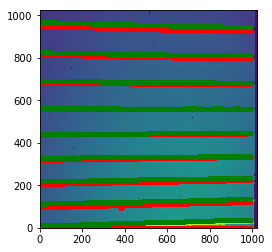

In [9]:
orderSeparation, orderStartEnd = ru.findOrderSeparationFromFlatByVertCut(flatHR, 10, 1005, plot='yes')

In [10]:
np.array(rawSpec_offSet['1'][0])

array([[ 66. ,  61. ,  56. , ...,  41. ,  40. ,  47. ],
       [ 77. ,  61. ,  78. , ...,  29. ,  26. ,  36. ],
       [ 68. ,  56. ,  71. , ...,  32. ,  42. ,  32. ],
       ..., 
       [ 72. ,  71. ,  69. , ...,  37. ,  47. ,  38. ],
       [ 73. ,  77. ,  59. , ...,  35. ,  37. ,  37. ],
       [ 84. ,  80. ,  73. , ...,  28. ,  57. ,  37.5]])

In [11]:
orders = [52, 51, 50, 49, 48, 47, 46, 45]

flatByOrders = ru.splitImageByOrder(flatHR, orders, orderStartEnd)
specByOrders = {}
for i in range(1,8):
    img = eval('rawSpec_offSet[' +"'" + str(i) +"'"+ ']')[0]
    specByOrders[i]= ru.splitImageByOrder(img, orders, orderStartEnd)

spatRecFlat = ru.performSpatialRectification(flatByOrders, orders) 
spatRecImg = {}
for i in range(1, 8):
    spatRecImg[i]= ru.performSpatialRectification(specByOrders[i], orders)

/Users/ryleighfitzpatrick/anaconda2/lib/python2.7/site-packages/scipy/ndimage/interpolation.py:600: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


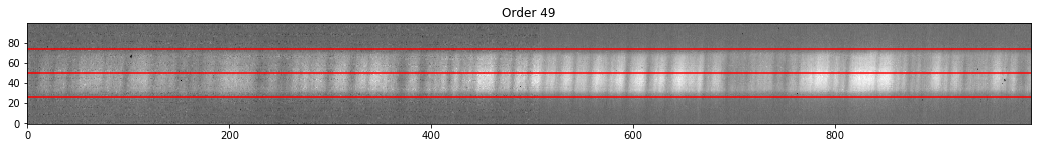

In [12]:
fig, ax = plt.subplots(figsize=(18, 2))
ax.imshow(spatRecImg[7][49], cmap='gray', origin='lower')
ax.title.set_text('Order 49')

ax.axhline(y = 26, color = 'r')
ax.axhline(y = 50, color = 'r')
ax.axhline(y = 74, color = 'r')

In [13]:
os.chdir(MainDirectory+'KECKspectra/')

modelSpec = np.loadtxt('ModelSpec_60')
modelSpec = np.column_stack((modelSpec[:,0], modelSpec[:,2]))

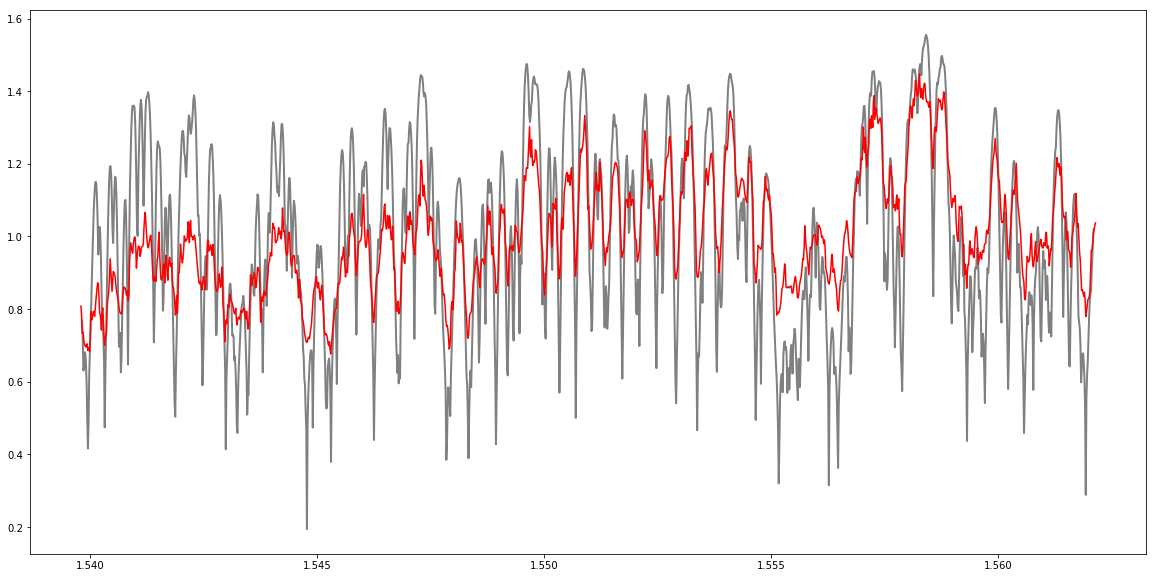

In [14]:
test, modelSpec = ru.peformSpecRecByOrderAndVertMedComb(spatRecImg[1], modelSpec, 49, 
                                                        [1.5398, 1.5621], [40, 50], plot='yes')

In [15]:
#Order 49
titanSpec= {}
avgSpec = {}
for offSet in range(1,8):
    avgSpec[offSet] = {}
    for spatRegion in range(1,26):
        titanSpec[spatRegion], modelSpec = ru.peformSpecRecByOrderAndVertMedComb(spatRecImg[offSet], modelSpec, 49, 
                                                                [1.5398, 1.5621], 
                                                                [int(25 + 2*(spatRegion-1)) , int(25 + 2*spatRegion)])
        index = np.where((titanSpec[spatRegion][:,0] <= 1.556) & (titanSpec[spatRegion][:,0] >= 1.55))
        avgSpec[offSet][spatRegion] = np.average(titanSpec[spatRegion][index[0][0]:index[0][-1], 1])

In [137]:
x = np.arange(0, 840)
y = np.arange(0, 840)
xy = np.meshgrid(x,y)

In [16]:
array = np.zeros((len(avgSpec.keys()),len(avgSpec[1].keys())))

for key1 in avgSpec.keys():
    for key2 in avgSpec[key1].keys():
        array[key1-1][key2-1] = avgSpec[key1][key2]

In [184]:
array = np.array(array)

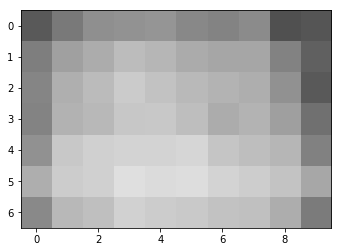

In [185]:
plt.imshow(array, cmap = 'gray', vmin = 0.95, vmax = 1.15)

In [ ]:
intensities = np.flip(np.swapaxes(array, 0, 1), 1)

In [ ]:
extent = [0,1024,0,1024]

fig = plt.figure(figsize = (10,10), frameon=False)

Z1 = intensities
Z2 = titanNASA
im1 = plt.imshow(Z1, cmap='gray', interpolation='nearest',
                 extent=[420, 750, 200, 800])
im2 = plt.imshow(Z2, cmap='gray', alpha=.5, interpolation='bilinear',
                 extent= extent)

for i in range(1,8):
    rect = patches.Rectangle((lowerX[i], lowerY), slitWidth, slitLength/2., 
                                                                 lw=2,edgecolor='cyan',facecolor='none')
    #im2.add_patch(rect)

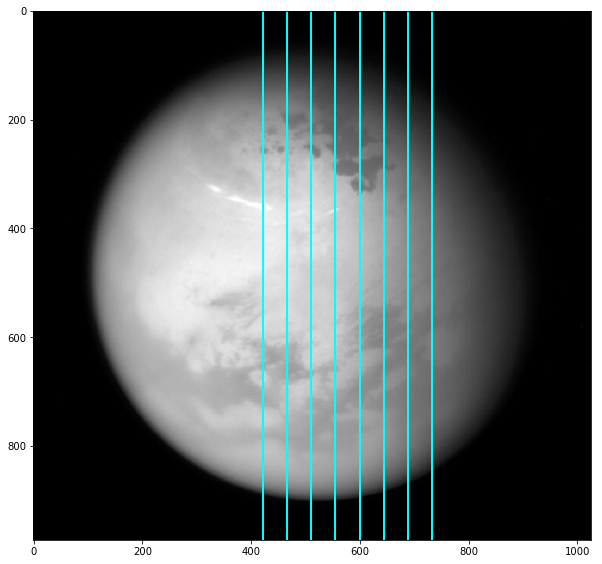

In [170]:
import matplotlib.patches as patches
circle1 = plt.Circle((520, 480), 420, color='r', fill=False, lw = 5)
rect = patches.Rectangle((lowerX[0], lowerY), slitWidth/2., slitLength/2., lw=2,edgecolor='cyan',facecolor='none')
rect1 = patches.Rectangle((lowerX[1], lowerY), slitWidth/2., slitLength/2., lw=2,edgecolor='cyan',facecolor='none')

fig, ax = plt.subplots(figsize = (10,10))
ax.imshow(titanNASA, cmap = "gray")
#ax.add_artist(circle1)
for i in range(1,8):
    rect = patches.Rectangle((lowerX[i], lowerY), slitWidth, slitLength/2., 
                                                                 lw=2,edgecolor='cyan',facecolor='none')
    ax.add_artist(rect)

In [168]:
import matplotlib.image as mpimg
os.chdir(MainDirectory)
titanNASA = mpimg.imread('Titan_jpg_NASA.jpg')

#Circle radius is 420 pixels- diameter is 840 pixels
#Titan is 0.777 arcsec in diameter
#Slit width is 0.041 arcsec, length is 2.26 arcsec

imgDiameter = 840.0
imgCenter = (520., 480.)

slitWidth = ((0.041/0.777) * imgDiameter)
slitLength = ((2.26/0.777) * imgDiameter)

lowerX = []

lowerX.append(imgCenter[0] - slitWidth/4.)
lowerY = imgCenter[1] - slitLength/4.

#Start 0.1554 arcsec east of center
lowerX.append(imgCenter[0] + imgDiameter*(0.1554/0.777))

#Shift over by 0.041 arcsec west 7 times
for i in range(1,7):
    lowerX.append(lowerX[i] - imgDiameter*(0.041/0.777))

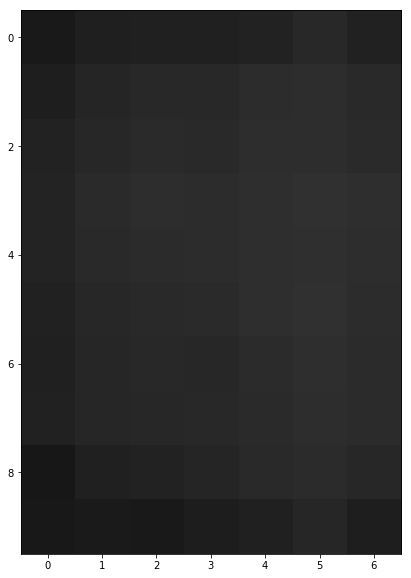

In [211]:
import matplotlib.patches as patches
circle1 = plt.Circle((520, 480), 420, color='r', fill=False, lw = 5)
rect = patches.Rectangle((lowerX[0], lowerY), slitWidth/2., slitLength/2., lw=2,edgecolor='cyan',facecolor='none')
rect1 = patches.Rectangle((lowerX[1], lowerY), slitWidth/2., slitLength/2., lw=2,edgecolor='cyan',facecolor='none')

fig, ax = plt.subplots(figsize = (10,10), sharex=True)
ax.imshow(titanNASA, cmap = "gray", alpha = 0.9)
ax.imshow(np.swapaxes(array, 0, 1), cmap= 'gray', alpha = 0.1)
#, extent = [lowerX[1], lowerX[-1], 200, 800])
#ax.add_artist(circle1)
for i in range(1,8):
    rect = patches.Rectangle((lowerX[i], lowerY), slitWidth, slitLength/2., 
                                        lw=2,edgecolor='cyan',facecolor='none')
    ax.add_artist(rect)
    
